STAT 479: Machine Learning (Fall 2018)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  
Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat479-fs2018/

# L10: Model Evaluation 3 -- Cross-Validation and Model Selection

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,mlxtend,matplotlib,sklearn

Sebastian Raschka 
last updated: 2018-11-08 

CPython 3.6.7
IPython 6.5.0

numpy 1.15.1
mlxtend 0.14.0dev
matplotlib 3.0.1
sklearn 0.20.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

- note to students: with matplotlib 3.0 you don't need `%matplotlib inline` in the notebook anymore; for older matplotlib versions you need to add that though to display the results in the notebook (so, please check via watermark when you are running this)

<p style="margin-bottom:5cm;"></p>

## K-fold Cross-Validation in Scikit-Learn

- Simple demonstration of using a cross-validation iterator in scikit-learn

In [3]:
from sklearn.model_selection import KFold


rng = np.random.RandomState(123)

y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
X = rng.random_sample((y.shape[0], 4))


cv = KFold(n_splits=5)

for k in cv.split(X, y):
    print(k)

(array([2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1]))
(array([0, 1, 4, 5, 6, 7, 8, 9]), array([2, 3]))
(array([0, 1, 2, 3, 6, 7, 8, 9]), array([4, 5]))
(array([0, 1, 2, 3, 4, 5, 8, 9]), array([6, 7]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([8, 9]))


<p style="margin-bottom:5cm;"></p>

- In practice, we are usually interested in shuffling the dataset, because if the data records are ordered by class label, this would result in cases where the classes are not well represented in the training and test folds

In [4]:
cv = KFold(n_splits=5, random_state=123, shuffle=True)

for k in cv.split(X, y):
    print(k)

(array([1, 2, 3, 5, 6, 7, 8, 9]), array([0, 4]))
(array([0, 1, 2, 3, 4, 6, 8, 9]), array([5, 7]))
(array([0, 1, 2, 4, 5, 6, 7, 9]), array([3, 8]))
(array([0, 2, 3, 4, 5, 7, 8, 9]), array([1, 6]))
(array([0, 1, 3, 4, 5, 6, 7, 8]), array([2, 9]))


<p style="margin-bottom:5cm;"></p>

- Note that the `KFold` iterator only provides us with the array indices; in practice, we are actually interested in the array values (feature values and class labels)

In [5]:
cv = KFold(n_splits=5, random_state=123, shuffle=True)

for train_idx, valid_idx in cv.split(X, y):
    print('train labels with shuffling', y[train_idx])

train labels with shuffling [0 0 0 1 1 1 1 1]
train labels with shuffling [0 0 0 0 0 1 1 1]
train labels with shuffling [0 0 0 0 1 1 1 1]
train labels with shuffling [0 0 0 0 1 1 1 1]
train labels with shuffling [0 0 0 0 1 1 1 1]


<p style="margin-bottom:5cm;"></p>

- As discussed in the lecture, it's important to stratify the splits (very crucial for small datasets!)

In [6]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

for train_idx, valid_idx in cv.split(X, y):
    print('train labels', y[train_idx])

train labels [0 0 0 0 1 1 1 1]
train labels [0 0 0 0 1 1 1 1]
train labels [0 0 0 0 1 1 1 1]
train labels [0 0 0 0 1 1 1 1]
train labels [0 0 0 0 1 1 1 1]


<p style="margin-bottom:5cm;"></p>

- After the illustrations of cross-validation above, the next cell demonstrates how we can actually use the iterators provided through scikit-learn to fit and evaluate a learning algorithm

In [7]:
from sklearn.tree import DecisionTreeClassifier
from mlxtend.data import iris_data
from sklearn.model_selection import train_test_split


X, y = iris_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.15, 
                                                    shuffle=True, stratify=y)



cv = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)

kfold_acc = 0.
for train_idx, valid_idx in cv.split(X_train, y_train):
    clf = DecisionTreeClassifier(random_state=123, max_depth=3).fit(X_train[train_idx], y_train[train_idx])
    y_pred = clf.predict(X_train[valid_idx])
    acc = np.mean(y_pred == y_train[valid_idx])*100
    kfold_acc += acc
kfold_acc /= 10
    
clf = DecisionTreeClassifier(random_state=123, max_depth=3).fit(X_train, y_train)
y_pred = clf.predict(X_test)
test_acc = np.mean(y_pred == y_test)*100
    
print('Kfold Accuracy: %.2f%%' % kfold_acc)
print('Test Accuracy: %.2f%%' % test_acc)

Kfold Accuracy: 95.06%
Test Accuracy: 95.65%


<p style="margin-bottom:5cm;"></p>

- Usually, a more convenient way to use cross-validation through scikit-learn is to use the `cross_val_score` function (note that it performs stratifies splitting for classification by default)
- (remember to ask students about whitespaces according to pep8)

In [8]:
from sklearn.model_selection import cross_val_score


cv_acc = cross_val_score(estimator=DecisionTreeClassifier(random_state=123, max_depth=3),
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=-1)

print('Kfold Accuracy: %.2f%%' % (np.mean(cv_acc)*100))

Kfold Accuracy: 96.83%


<p style="margin-bottom:5cm;"></p>

- `cross_val_score` has unfortunately no way to specify a random seed; this is not an issue in regular use cases, but it is not useful if you want to do "repeated cross-validation"
- The next cell illustrates how we can provide our own cross-validation iterator for convenience (note that the results match or "manual" `StratifiedKFold` approach we performed earlier)

In [9]:
from sklearn.model_selection import cross_val_score


cv_acc = cross_val_score(estimator=DecisionTreeClassifier(random_state=123, max_depth=3),
                         X=X_train,
                         y=y_train,
                         cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                         n_jobs=-1)

print('Kfold Accuracy: %.2f%%' % (np.mean(cv_acc)*100))

Kfold Accuracy: 95.06%


<p style="margin-bottom:5cm;"></p>

##  Bootstrap

- Recall Bootstrapping from 2 lectures ago? Here I is an iterator I implemented analogous to `KFold`

In [10]:
from mlxtend.evaluate import BootstrapOutOfBag

oob = BootstrapOutOfBag(n_splits=5, random_seed=123)
for train, test in oob.split(np.array([1, 2, 3, 4, 5])):
    print(train, test)

[2 4 2 1 3] [0]
[2 3 1 1 0] [4]
[1 1 0 0 1] [2 3 4]
[3 4 0 0 4] [1 2]
[1 3 2 4 2] [0]


<p style="margin-bottom:5cm;"></p>

- Analagous the `KFold` iterator, we can use it in the `cross_val_score` function for convenience

In [11]:
cv_acc = cross_val_score(estimator=DecisionTreeClassifier(random_state=123, max_depth=3),
                         X=X_train,
                         y=y_train,
                         cv=BootstrapOutOfBag(n_splits=200, random_seed=123),
                         n_jobs=-1)

print('OOB Bootstrap Accuracy: %.2f%%' % (np.mean(cv_acc)*100))

OOB Bootstrap Accuracy: 95.05%


<p style="margin-bottom:5cm;"></p>

- Analagous to the `cross_val_score` method, you can use the `bootstrap_point632_score`, which implements the .632-Bootstrap method (which is less pesimistically biased than the out-of-bag bootstrap)

In [12]:
from mlxtend.evaluate import bootstrap_point632_score


cv_acc = bootstrap_point632_score(estimator=DecisionTreeClassifier(random_state=123, max_depth=3),
                                  X=X_train,
                                  y=y_train,
                                  random_seed=123)

print('OOB Bootstrap Accuracy: %.2f%%' % (np.mean(cv_acc)*100))

OOB Bootstrap Accuracy: 96.34%


<p style="margin-bottom:5cm;"></p>


## GridSearch

- For hyperparameter tuning and model selection, `GridSearchCV` is really useful

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, None],
               'criterion': ['gini', 'entropy']}]

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                  param_grid=param_grid,
                  iid=False,
                  refit=True,
                  n_jobs=-1,
                  cv=10)

gs.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

Best Accuracy: 96.83%
Best Params: {'criterion': 'gini', 'max_depth': 3}


In [14]:
for i in range(len(gs.cv_results_['mean_test_score'])):
    print(gs.cv_results_['mean_test_score'][i], gs.cv_results_['params'][i]) 

0.6692307692307693 {'criterion': 'gini', 'max_depth': 1}
0.9123076923076923 {'criterion': 'gini', 'max_depth': 2}
0.9683333333333334 {'criterion': 'gini', 'max_depth': 3}
0.9533333333333334 {'criterion': 'gini', 'max_depth': 4}
0.9616666666666666 {'criterion': 'gini', 'max_depth': 5}
0.9616666666666666 {'criterion': 'gini', 'max_depth': 6}
0.9616666666666666 {'criterion': 'gini', 'max_depth': None}
0.6692307692307693 {'criterion': 'entropy', 'max_depth': 1}
0.9123076923076923 {'criterion': 'entropy', 'max_depth': 2}
0.9606410256410255 {'criterion': 'entropy', 'max_depth': 3}
0.9456410256410257 {'criterion': 'entropy', 'max_depth': 4}
0.9462820512820512 {'criterion': 'entropy', 'max_depth': 5}
0.9539743589743589 {'criterion': 'entropy', 'max_depth': 6}
0.9539743589743589 {'criterion': 'entropy', 'max_depth': None}


- After running `GridSearchCV`, we would fit a model with the best settings (hyperparameters on the whole training set
- By default, `GridSearchCV` already does this for us (unless, we set `refit=False`), so that we can evaluate the performance of the model on the test set

In [15]:
print('Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

Accuracy: 95.65%


Note that if we do not set refit=True, we would have to manually refit the model based on the best parameter values, like illustrated below

In [16]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                  param_grid=param_grid,
                  iid=False,
                  refit=False,
                  n_jobs=-1,
                  cv=10)

gs.fit(X_train, y_train)
tree = DecisionTreeClassifier(random_state=123, **gs.best_params_)
tree.fit(X_train, y_train)

print('Accuracy: %.2f%%' % (tree.score(X_test, y_test)*100))

Accuracy: 95.65%


<p style="margin-bottom:5cm;"></p>

- `GridSearchCV` is also compatible with the .632-Bootstrap iterator we defined earlier

In [17]:
from sklearn.model_selection import GridSearchCV


param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, None],
               'criterion': ['gini', 'entropy']}]

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                  param_grid=param_grid,
                  iid=False,
                  refit=True,
                  cv=BootstrapOutOfBag(n_splits=200, random_seed=123))

gs.fit(X_train, y_train)
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)
print('Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

Best Accuracy: 95.12%
Best Params: {'criterion': 'entropy', 'max_depth': 3}
Accuracy: 95.65%


<p style="margin-bottom:5cm;"></p>

- Note that feature scaling is unnecessary when we are using decsion trees, however it DOES matter in most other learning algorithms, including k-Nearest-Neighbors
- To avoid introducing bias, we have to compute the parameters for scaling (e.g., the mean and standard deviation in context of z-score normalization) on the training fold to scale the training AND test fold in a given iteration
- To make this more convenient, this is where scikit-learn's `Pipeline` class (or `make_pipeline` function) comes in handy as the next cell demonstrates

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier


pipe = make_pipeline(StandardScaler(), 
                     KNeighborsClassifier())

param_grid = [{'kneighborsclassifier__n_neighbors': list(range(1, 16)),
               'kneighborsclassifier__p': [1, 2]}]


gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  iid=False,
                  n_jobs=-1,
                  refit=True,
                  cv=BootstrapOutOfBag(n_splits=200, random_seed=123))

gs.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)
print('Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

Best Accuracy: 94.78%
Best Params: {'kneighborsclassifier__n_neighbors': 12, 'kneighborsclassifier__p': 1}
Accuracy: 91.30%


<p style="margin-bottom:5cm;"></p>

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint as sp_randint


np.random.seed(123)

pipe = make_pipeline(StandardScaler(), 
                     KNeighborsClassifier())

param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 21),
              'kneighborsclassifier__p': [1, 2]}


gs = RandomizedSearchCV(estimator=pipe,
                        param_distributions=param_dist,
                        n_iter=1000,
                        iid=False,
                        n_jobs=-1,
                        refit=True,
                        cv=10)

gs.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)
print('Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

Best Accuracy: 96.00%
Best Params: {'kneighborsclassifier__n_neighbors': 14, 'kneighborsclassifier__p': 1}
Accuracy: 91.30%


<p style="margin-bottom:5cm;"></p>


## K-fold and standard deviation (1-standard error method)

- Below is an application of the 1-standard error method we discussed in class (to select hyperparameters according to the "Law of Parsimony")

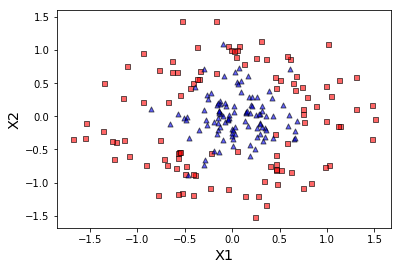

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles


X, y = make_circles(n_samples=300, random_state=1, noise=0.275, factor=0.2)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=12345,
                                                    stratify=y)

plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], 
            marker='s', color='red', edgecolor='k', alpha=0.6, s=25)
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], 
            marker='^', color='blue', edgecolor='k', alpha=0.6, s=25)
plt.xlabel('X1', fontsize=14.5)
plt.ylabel('X2', fontsize=14.5)

plt.show()

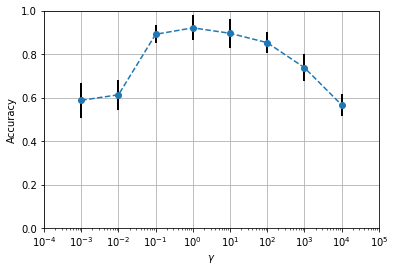

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

params = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
cv_acc, cv_std, cv_stderr = [], [], []


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for c in params:

    clf = SVC(C=10.0, 
              kernel='rbf', 
              degree=1, 
              gamma=c, 
              coef0=0.0, 
              shrinking=True, 
              probability=False, 
              tol=0.001, 
              cache_size=200, 
              class_weight=None, 
              verbose=False, 
              max_iter=-1, 
              decision_function_shape=None, 
              random_state=0)

    
    all_acc = []
    for train_index, valid_index in cv.split(X_train, y_train):
        pred = clf.fit(X_train[train_index], y_train[train_index])\
               .predict(X_train[valid_index])
        acc = np.mean(y_train[valid_index] == pred)
        all_acc.append(acc)

    all_acc = np.array(all_acc)
    y_pred_cv10_mean = all_acc.mean()
    y_pred_cv10_std = all_acc.std()
    y_pred_cv10_stderr = y_pred_cv10_std / np.sqrt(10)

    cv_acc.append(y_pred_cv10_mean) 
    cv_std.append(y_pred_cv10_std)
    cv_stderr.append(y_pred_cv10_stderr)
    

## PLOTTING

ax = plt.subplot(111)
ax.set_xscale('log')
ax.errorbar(params, cv_acc, yerr=cv_std, fmt='--o', ecolor='black', elinewidth=2)


plt.ylim([0.0, 1.0])
plt.xlim([0.0001, 100000.0])
plt.grid()
plt.xlabel('$\\gamma$')
plt.ylabel('Accuracy')
plt.show()

<p style="margin-bottom:5cm;"></p>

- Below is a visualization of the decision boundary of the "most parsimonious" hyperparameter choice

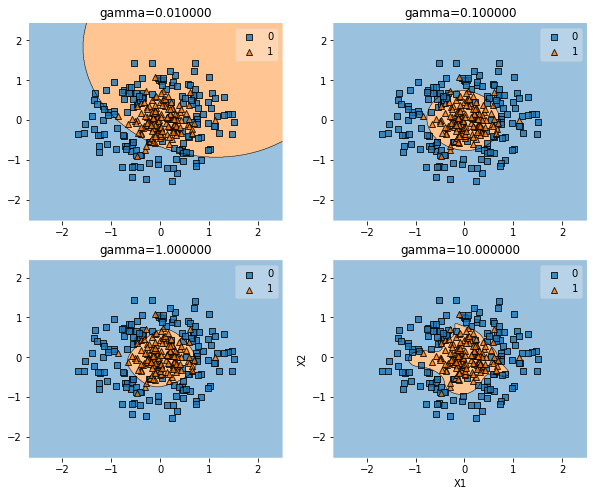

In [22]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools


gspec = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))

for c, grd in zip([0.01, 0.1, 1.0, 10.], itertools.product([0, 1], repeat=2)):

    clf = SVC(C=10.0, 
              kernel='rbf', 
              degree=1, 
              gamma=c, 
              coef0=0.0, 
              shrinking=True, 
              probability=False, 
              tol=0.001, 
              cache_size=200, 
              class_weight=None, 
              verbose=False, 
              max_iter=-1, 
              decision_function_shape=None, 
              random_state=0)

    clf.fit(X_train, y_train)
    ax = plt.subplot(gspec[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title('gamma=%f' % c)


plt.xlabel('X1') 
plt.ylabel('X2')

plt.show()

<p style="margin-bottom:5cm;"></p>

- The following cells in this section repeat the procedure of choosing the most parsimonious hyperparameter using decision trees and two features of the Iris dataset (petal length and petal width)

In [23]:
from mlxtend.data import iris_data
from sklearn.model_selection import train_test_split


X, y = iris_data()
X = X[:, [2, 3]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.15, 
                                                    shuffle=True, stratify=y)


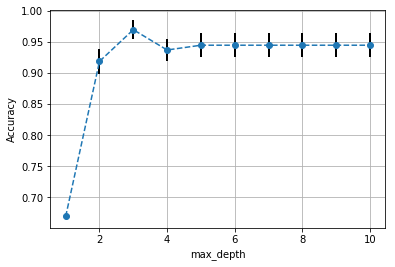

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold


params = range(1, 11)
cv_acc, cv_std, cv_stderr = [], [], []


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for c in params:

    clf = DecisionTreeClassifier(random_state=123, max_depth=c)

    
    all_acc = []
    for train_index, valid_index in cv.split(X_train, y_train):
        pred = clf.fit(X_train[train_index], y_train[train_index])\
               .predict(X_train[valid_index])
        acc = np.mean(y_train[valid_index] == pred)
        all_acc.append(acc)

    all_acc = np.array(all_acc)
    y_pred_cv10_mean = all_acc.mean()
    y_pred_cv10_std = all_acc.std()
    y_pred_cv10_stderr = y_pred_cv10_std / np.sqrt(10)

    cv_acc.append(y_pred_cv10_mean) 
    cv_std.append(y_pred_cv10_std)
    cv_stderr.append(y_pred_cv10_stderr)
    

## PLOTTING

ax = plt.subplot(111)
ax.errorbar(params, cv_acc, yerr=cv_stderr, fmt='--o', ecolor='black', elinewidth=2)


plt.grid()
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()

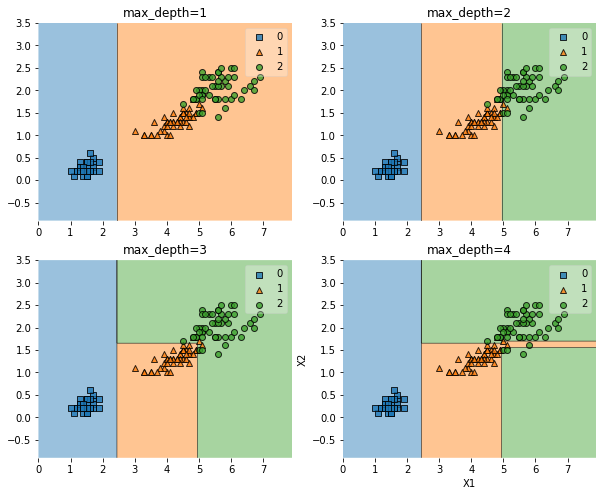

In [25]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools


gspec = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))

for c, grd in zip([1, 2, 3, 4], itertools.product([0, 1], repeat=2)):

    clf = DecisionTreeClassifier(random_state=123, max_depth=c)

    clf.fit(X_train, y_train)
    ax = plt.subplot(gspec[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title('max_depth=%d' % c)


plt.xlabel('X1') 
plt.ylabel('X2')

plt.show()

<p style="margin-bottom:5cm;"></p>

## Repeated k-fold

- The following code compares "single" k-fold runs with repeated k-fold cross-validation (repeating k-fold 50 times with different random seeds)

In [26]:
# SINGLE RUN

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

params = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
cv_acc, cv_std, cv_stderr = [], [], []


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for c in params:

    clf = SVC(C=10.0, 
              kernel='rbf', 
              degree=1, 
              gamma=c, 
              coef0=0.0, 
              shrinking=True, 
              probability=False, 
              tol=0.001, 
              cache_size=200, 
              class_weight=None, 
              verbose=False, 
              max_iter=-1, 
              decision_function_shape=None, 
              random_state=0)

    
    all_acc = []
    for train_index, valid_index in cv.split(X_train, y_train):
        pred = clf.fit(X_train[train_index], y_train[train_index])\
               .predict(X_train[valid_index])
        acc = np.mean(y_train[valid_index] == pred)
        all_acc.append(acc)

    all_acc = np.array(all_acc)
    y_pred_cv10_mean = all_acc.mean()
    y_pred_cv10_std = all_acc.std()
    y_pred_cv10_stderr = y_pred_cv10_std / np.sqrt(10)

    cv_acc.append(y_pred_cv10_mean) 
    cv_std.append(y_pred_cv10_std)
    cv_stderr.append(y_pred_cv10_stderr)

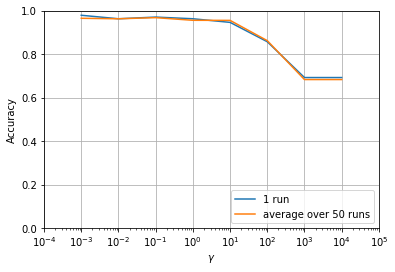

In [27]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold


rng = np.random.RandomState(seed=12345)
seeds = np.arange(10**5)
rng.shuffle(seeds)
seeds = seeds[:50]


params = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
cv_acc_rep, cv_std_rep, cv_stderr_rep = [], [], []

for c in params:

    clf = SVC(C=10.0, 
              kernel='rbf', 
              degree=1, 
              gamma=c, 
              coef0=0.0, 
              shrinking=True, 
              probability=False, 
              tol=0.001, 
              cache_size=200, 
              class_weight=None, 
              verbose=False, 
              max_iter=-1, 
              decision_function_shape=None, 
              random_state=0)


    ###########################
    ## 50 RUNS, aggregated
    ###########################


    all_acc = []

    for r in range(50):

        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seeds[r])

        for train_index, valid_index in cv.split(X_train, y_train):
            pred = clf.fit(X_train[train_index], y_train[train_index])\
                   .predict(X_train[valid_index])
            acc = np.mean(pred == y_train[valid_index])
            all_acc.append(acc)

    all_acc = np.array(all_acc)

    cv_acc_rep.append(np.mean(all_acc))
    cv_std_rep.append(np.std(all_acc))
    cv_stderr_rep.append(np.std(all_acc) / np.sqrt(all_acc.shape[0]))

    
## PLOTTING

ax = plt.subplot(111)
ax.set_xscale('log')
ax.plot(params, cv_acc, label='1 run')
ax.plot(params, cv_acc_rep, label='average over 50 runs')



plt.ylim([0.0, 1.0])
plt.xlim([0.0001, 100000.0])
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('$\\gamma$')
plt.ylabel('Accuracy')
plt.show()